# Reproduction Instructions

Others
1. Navigate to `/scripts/`
2. Execute `get_suburbs_shp.py`
3. Execute `/notebooks/PTVdataProcessing.ipynb`

House Speaking Same
1. Navigate to `/scripts/housespeakingsame`
2. Execute `scrape_house_speakingsame_suburbs.py`
3. Execute `preprocess_house_speakingsame_suburbs.py`
4. Execute `scrape_house_speakingsame_schools.py`

In [191]:
import pandas as pd
import geopandas as gpd
from glob import glob
import folium
from datetime import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

TOP_SUB_DATA_DIR = "../data/curated/housespeakingsame/top/"
SCHOOLS_PATH = "../data/raw/housespeakingsame/schools/top_schools.csv"
PTV_PATH = '../data/curated/PTV_stations_count_by_suburb.csv'
shp_file = "../data/raw/suburbs/SAL_2021_AUST_GDA2020.shp"

In [192]:
sf = gpd.read_file(shp_file)
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
vic_sf = sf.query("STE_NAME21=='Victoria'")

In [115]:
sub_df = pd.DataFrame(columns = ['suburb'])
for p in glob(TOP_SUB_DATA_DIR + '*'):
    name = p.split('/')[-1].split('.')[0]
    d = pd.read_csv(p, index_col=0)[['suburb','rank','value']]
    d[name] = d['value']
    d[name + '_rank'] = d['rank']
    d = d.drop(['value', 'rank'], axis=1)
    sub_df = sub_df.merge(d, on='suburb', how='outer')
sub_df = sub_df.sort_values('rent_rank')

In [116]:
schools = pd.read_csv(SCHOOLS_PATH)

In [117]:
school_ranks = schools.groupby('suburb')['rank'].agg(['min','mean','max']).reset_index().set_index('suburb')
school_ranks.columns = ['school_rank_' + c for c in school_ranks.columns]
school_counts = schools.groupby('suburb')['type'].value_counts().reset_index(name='count').pivot('suburb','type','count').reset_index().fillna(0)
school_counts['total'] = school_counts.drop('suburb', axis=1).sum(axis=1)
school_counts = school_counts.sort_values('total').set_index('suburb')
school_counts.columns = ['schools_' + c for c in school_counts.columns]

In [118]:
sub_schools = school_counts.merge(school_ranks, left_index=True, right_index=True, how='outer').reset_index()

In [155]:
ptv = pd.read_csv(PTV_PATH, index_col=0).fillna(0)
ptv['suburb'] = ptv['suburb'].str.lower().str.capitalize()

In [243]:
ptv.columns = ['suburb', 'Train', 'Tram', 'Bus', 'Total Stations']

In [244]:
sub = sub_df.merge(sub_schools, on='suburb', how='outer').merge(ptv, on='suburb', how='left')

In [246]:
fill0_cols = ['rented', 'education', 'turnover', 'owned', 'houses', 'occupation',
              'flats', 'purchased', 'schools_Combined', 'schools_Primary', 'schools_Secondary',
              'schools_total', 'Train', 'Tram', 'Bus', 'Total Stations']
sub[fill0_cols] = sub[fill0_cols].fillna(0)
sub = sub.rename({'suburb': 'Suburb'}, axis=1)

# Analyses

## Public Transport

<AxesSubplot:title={'center':'Suburbs with Top 10 Total PTV Station Counts'}, ylabel='Suburb'>

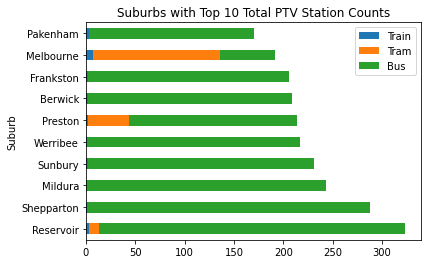

In [255]:
sub.nlargest(10, 'Total Stations')[['Suburb','Train','Tram','Bus','Total Stations']].plot(
    kind='barh', x='Suburb', y=['Train','Tram','Bus'], stacked=True, title='Suburbs with Top 10 Total PTV Station Counts')

<AxesSubplot:title={'center':'Suburbs with Top 10 Tram Station Counts'}, ylabel='Suburb'>

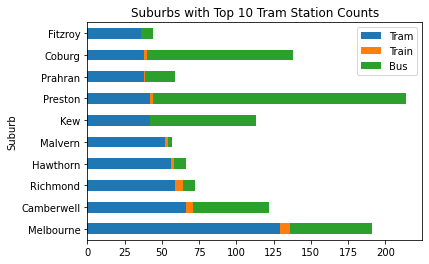

In [256]:
sub.nlargest(10, 'Tram')[['Suburb','Train','Tram','Bus','Total Stations']].plot(
    kind='barh', x='Suburb', y=['Tram','Train','Bus'], stacked=True, title='Suburbs with Top 10 Tram Station Counts')

## Education

In [267]:
sub.columns

Index(['Suburb', 'rented', 'rented_rank', 'education', 'education_rank',
       'turnover', 'turnover_rank', 'owned', 'owned_rank', 'houses',
       'houses_rank', 'income', 'income_rank', 'sold', 'sold_rank', 'rent',
       'rent_rank', 'occupation', 'occupation_rank', 'flats', 'flats_rank',
       'purchased', 'purchased_rank', 'schools_Combined', 'schools_Primary',
       'schools_Secondary', 'schools_total', 'school_rank_min',
       'school_rank_mean', 'school_rank_max', 'Train', 'Tram', 'Bus',
       'Total Stations'],
      dtype='object')

In [270]:
educ = sub[['Suburb', 'education', 'education_rank', 'schools_Combined', 'schools_Primary',
       'schools_Secondary', 'schools_total', 'school_rank_min',
       'school_rank_mean', 'school_rank_max']].copy()
educ.columns = ['Suburb', 'Tertiary', 'Tertiary Rank', 'Combined', 'Primary',
       'Secondary', 'Schools', 'HS Rank (min)',
       'HS Rank (avg)', 'HS Rank (max)']
educ.nlargest(10, 'Tertiary')

,Suburb,Tertiary,Tertiary Rank,Combined,Primary,Secondary,Schools,HS Rank (min),HS Rank (avg),HS Rank (max)
68,Parkville,51.0,1.0,0.0,0.0,1.0,1.0,83.0,83.000000,83.0
88,Carlton,33.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1088,Carlton South,33.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
313,Melbourne,24.0,3.0,2.0,0.0,1.0,3.0,1.0,34.666667,79.0
127,North Melbourne,20.0,4.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
205,Southbank,20.0,4.0,0.0,0.0,1.0,1.0,61.0,61.000000,61.0
296,Clayton,20.0,4.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
397,Notting Hill,20.0,4.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
27,Princes Hill,19.0,5.0,0.0,0.0,1.0,1.0,86.0,86.000000,86.0
80,Carlton North,19.0,5.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN


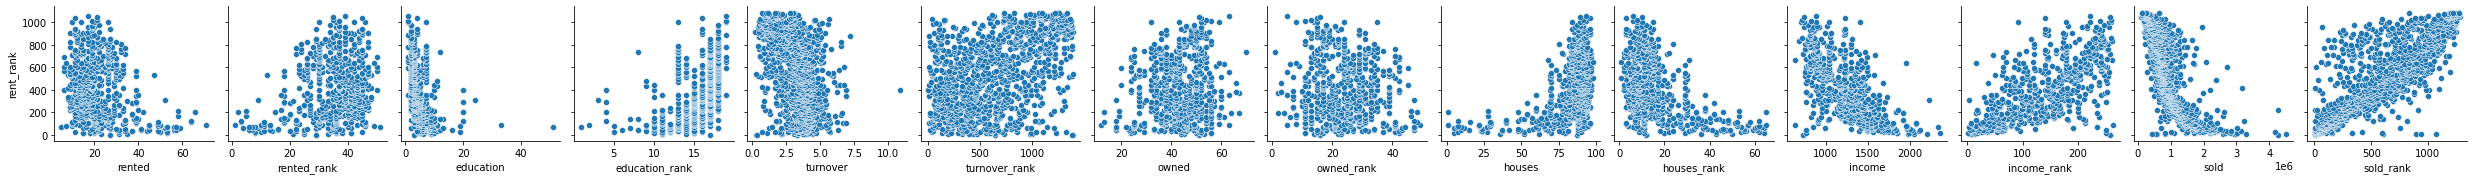

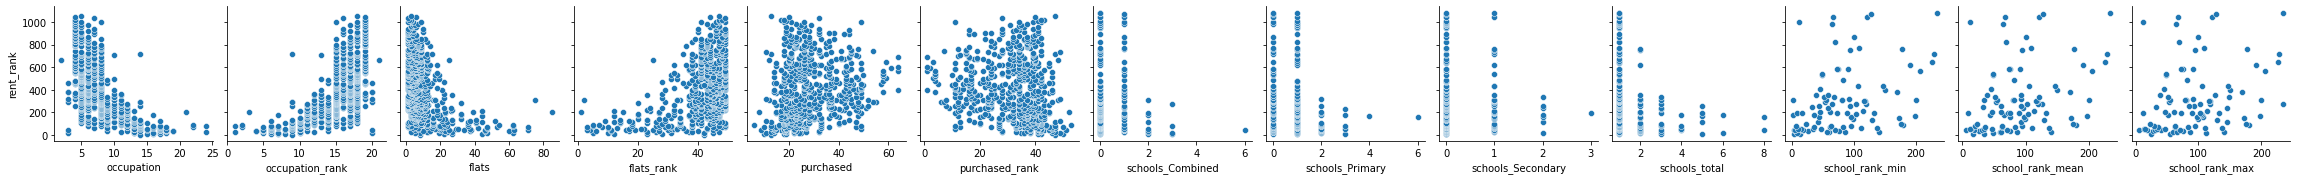

In [127]:
# fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.pairplot(sub, x_vars=['rented', 'rented_rank', 'education', 'education_rank',
       'turnover', 'turnover_rank', 'owned', 'owned_rank', 'houses',
       'houses_rank', 'income', 'income_rank', 'sold', 'sold_rank'], y_vars = ['rent_rank'])
plt.show()
sns.pairplot(sub, x_vars=['occupation', 'occupation_rank', 'flats', 'flats_rank',
       'purchased', 'purchased_rank', 'schools_Combined', 'schools_Primary',
       'schools_Secondary', 'schools_total', 'school_rank_min',
       'school_rank_mean', 'school_rank_max'], y_vars = ['rent_rank'])

In [139]:
s

,suburb,rented,rented_rank,education,education_rank,turnover,turnover_rank,owned,owned_rank,houses,...,flats_rank,purchased,purchased_rank,schools_Combined,schools_Primary,schools_Secondary,schools_total,school_rank_min,school_rank_mean,school_rank_max
0,False,True,True,True,True,False,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,True,True
2,False,True,True,True,True,False,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,False,True,True,True,True,False,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,False,True,True,True,True,False,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,False,True,True,True,True,True,True,True,True,True,...,True,True,True,False,False,False,False,True,True,True
1424,False,True,True,True,True,True,True,True,True,True,...,True,True,True,False,False,False,False,True,True,True
1425,False,True,True,True,True,True,True,True,True,True,...,True,True,True,False,False,False,False,True,True,True
1426,False,True,True,True,True,True,True,True,True,True,...,True,True,True,False,False,False,False,False,False,False


In [141]:
sub

,suburb,rented,rented_rank,education,education_rank,turnover,turnover_rank,owned,owned_rank,houses,...,flats_rank,purchased,purchased_rank,schools_Combined,schools_Primary,schools_Secondary,schools_total,school_rank_min,school_rank_mean,school_rank_max
0,Mount Buller,NaN,NaN,NaN,NaN,0.31,1384.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Falls Creek,27.0,29.0,3.0,17.0,0.38,1381.0,51.0,16.0,87.0,...,42.0,13.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Flinders,NaN,NaN,NaN,NaN,3.29,642.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sawmill Settlement,NaN,NaN,NaN,NaN,3.77,452.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Portsea,NaN,NaN,NaN,NaN,2.18,975.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,Dederang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,1.0,0.0,1.0,NaN,NaN,NaN
1424,East Malvern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,1.0,0.0,1.0,NaN,NaN,NaN
1425,Lower Templestowe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,1.0,0.0,1.0,NaN,NaN,NaN
1426,Monash University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,1.0,7.0,7.0,7.0


<AxesSubplot:>

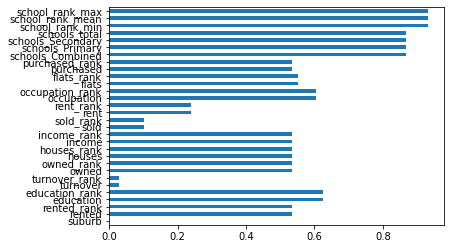

In [138]:
sub.isna().mean().plot.barh()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

clf = Pipeline([StandardScaler(), Lass()])
clf.fit()

<AxesSubplot:>

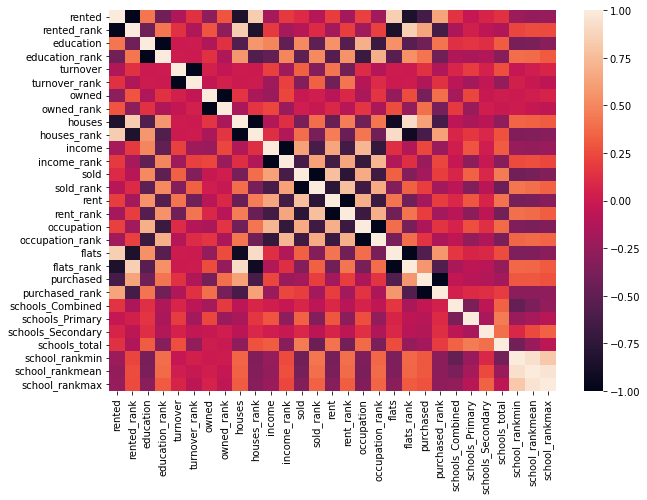

In [104]:
plt.subplots(1,1,figsize=(10,7))
sns.heatmap(sub.corr(method='spearman'))

In [43]:
schools_all = pd.read_excel('../data/raw/abs_data/education.xlsx', sheet_name = 3, skiprows = 4)

schools = schools_all.loc[schools_all['State/Territory'] == 'b Vic.']

In [44]:
schools

,Year,State/Territory,Affiliation (Gov/Non-gov),Affiliation (Gov/Cath/Ind),School Type,School Count
12,2021,b Vic.,a Government,a Government,a Primary school,1137.0
13,2021,b Vic.,a Government,a Government,b Secondary school,247.0
14,2021,b Vic.,a Government,a Government,c Combined school,82.0
15,2021,b Vic.,a Government,a Government,d Special school,81.0
16,2021,b Vic.,b Non-Government,b Catholic,a Primary school,394.0
...,...,...,...,...,...,...
1045,2010,b Vic.,b Non-Government,b Catholic,d Special school,8.0
1046,2010,b Vic.,b Non-Government,c Independent,a Primary school,46.0
1047,2010,b Vic.,b Non-Government,c Independent,b Secondary school,15.0
1048,2010,b Vic.,b Non-Government,c Independent,c Combined school,140.0
